In [ ]:
import astropy
from astropy.io import fits
from astropy import units as u
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare
import math
!pip install astroquery
!pip install gaiaxpy
from astropy.coordinates import Angle
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from astroquery.gaia import GaiaClass
import astropy.coordinates as coord
from gaiaxpy import calibrate
from ast import literal_eval
from gaiaxpy import plot_spectra

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

## import/function

In [ ]:
csv_file_path = "/content/drive/MyDrive/AstroResearch/new_data_table/Optical_spectral_types_DR17_v3_ctheissen.csv"
df = pd.read_csv(csv_file_path)
original_df = df.drop_duplicates(subset='bestObjID', keep='first').reset_index(drop=True)
original_df

,mjd,plate,fiberID,bestObjID,ra,dec,class,subclass,instrument,rChi2,...,psfMagErr_u,psfMagErr_g,psfMagErr_r,psfMagErr_i,psfMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z
0,56727,7456,532,1237648674511454293,196.713400,0.298453,STAR,A4V (97603),BOSS,1.881113,...,0.012358,0.011815,0.016474,0.024657,0.029614,0.071528,0.055734,0.038557,0.028652,0.021312
1,56727,7456,501,1237648674511454356,196.624950,0.282299,STAR,K3V (32147),BOSS,1.101248,...,0.070880,0.014013,0.016380,0.014305,0.023413,0.080341,0.062601,0.043307,0.032182,0.023937
2,56727,7456,531,1237648674511585290,196.900460,0.240210,STAR,G0 (63791),BOSS,1.112199,...,0.023038,0.014827,0.012288,0.014434,0.023888,0.083197,0.064826,0.044847,0.033326,0.024788
3,56727,7456,563,1237648674511585391,196.968910,0.349134,STAR,K3V (32147),BOSS,1.346109,...,0.039587,0.015189,0.012435,0.014620,0.024842,0.066900,0.052128,0.036062,0.026798,0.019933
4,56727,7456,571,1237648674511650951,197.030410,0.239345,STAR,K5Ve (118100),BOSS,3.276671,...,0.027482,0.015707,0.012603,0.013149,0.022902,0.073882,0.057568,0.039826,0.029595,0.022013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117961,57364,7715,622,1237680311769301325,8.753181,33.065267,STAR,G8V (101501),BOSS,1.072950,...,0.052898,0.016856,0.011773,0.013551,0.023144,0.338356,0.263645,0.182388,0.135534,0.100812
117962,56561,6293,346,1237680331096981717,343.825470,27.206893,STAR,F3/F5V (30743),BOSS,2.364043,...,0.018976,0.016089,0.011750,0.013114,0.026265,0.247947,0.193198,0.133654,0.099319,0.073875
117963,56566,6292,496,1237680331634376734,344.995420,27.781598,STAR,F3/F5V (30743),BOSS,1.104141,...,0.022101,0.014612,0.017602,0.028957,0.018391,0.254428,0.198248,0.137147,0.101915,0.075806
117964,57362,7718,44,1237680331644993617,12.683085,29.070565,STAR,F0IV (81937),BOSS,1.077174,...,0.018712,0.016770,0.013694,0.024185,0.021729,0.244040,0.190154,0.131548,0.097754,0.072711


In [ ]:
def to_gaia_id(SDSS_ID):
  ra1 = original_df[original_df.bestObjID == SDSS_ID]['ra']
  dec1 = original_df[original_df.bestObjID == SDSS_ID]['dec']
  result = Vizier.query_region(SkyCoord(ra=ra1*u.deg, dec=dec1*u.deg), \
                               radius=6*u.arcsec, catalog='I/355/gaiadr3') # we take 6arsec uncertainty into account
  return result[0]["Source"][0]
gaia_ID = to_gaia_id(1237651190811722019)

def chi_square_error_2(list1, list2, sigma2):

    arr1 = np.array(list1)
    arr2 = np.array(list2)
    sigma2 = np.array(sigma2)

    mask = (arr2 > 0)  # Create a boolean mask
    arr1_filtered = arr1[mask]
    arr2_filtered = arr2[mask]
    sigma2_filtered = sigma2[mask]

    chi_square = np.sum((arr1_filtered - arr2_filtered) ** 2 / sigma2_filtered)
    reduced_chi_square = chi_square / (len(arr1_filtered) - 1)

    return reduced_chi_square

!pip install pysynphot
import pysynphot as pysyn

def rebin_spec(wave, specin, wavnew): # new resample flux (from Chris)
    spec = pysyn.spectrum.ArraySourceSpectrum(wave=wave, flux=specin)
    f    = np.ones(len(wave))
    filt = pysyn.spectrum.ArraySpectralElement(wave, f, waveunits='angstrom')
    obs  = pysyn.observation.Observation(spec, filt, binset=wavnew, force='taper')
    return obs.binflux

def load_SDSS_star(spectrum_file):
    try:
        with fits.open(spectrum_file) as hdulist:
            table_data = hdulist[1].data
            data = {name: np.array(table_data[name]).byteswap().newbyteorder() for name in table_data.names}
        SDSS_star = pd.DataFrame(data)
        SDSS_star['loglam'] = 10 ** SDSS_star['loglam']
        SDSS_star.rename(columns={'loglam': 'wavelength'}, inplace=True)
        return SDSS_star
    except OSError:
        print(f"Error loading file: {spectrum_file}")
        return None

def load_template(template_file):
    with fits.open(template_file) as hdulist:
        table_data = hdulist[1].data
        data = {name: np.array(table_data[name]).byteswap().newbyteorder() for name in table_data.names}
    pyhammer_template = pd.DataFrame(data)
    pyhammer_template.rename(columns={'LogLam': 'wavelength', 'Flux': 'flux'}, inplace=True)
    pyhammer_template['wavelength'] = 10 ** pyhammer_template['wavelength']
    return pyhammer_template

In [ ]:
def calculate_chi_square(SDSS_star, A0_pyhammer):

    A0_pyhammer = A0_pyhammer.dropna(subset=['flux', 'Std'])

    min_wavelength = A0_pyhammer['wavelength'].min()
    max_wavelength = A0_pyhammer['wavelength'].max()

    SDSS_star = SDSS_star[(SDSS_star['wavelength'] >= min_wavelength) & (SDSS_star['wavelength'] <= max_wavelength)]

    # Resample Flux
    A0_new_flux = rebin_spec(A0_pyhammer['wavelength'].values, A0_pyhammer['flux'].values, SDSS_star['wavelength'].values)
    A0_new_Std = rebin_spec(A0_pyhammer['wavelength'].values, A0_pyhammer['Std'].values, SDSS_star['wavelength'].values)
    data = {'wavelength': SDSS_star['wavelength'].values, 'flux': A0_new_flux, 'Std': A0_new_Std}
    A0_template_resampled = pd.DataFrame(data)

    # normalize
    SDSS_star_filtered = SDSS_star[(SDSS_star['wavelength'] >= 7480) & (SDSS_star['wavelength'] <= 7520)]
    A0_template_resampled_filtered = A0_template_resampled[(A0_template_resampled['wavelength'] >= 7480) & (A0_template_resampled['wavelength'] <= 7520)]
    median1_SDSS = SDSS_star_filtered['flux'].median()
    median2_template = A0_template_resampled_filtered['flux'].median()

    wavelength = SDSS_star['wavelength'].values
    SDSS_flux = SDSS_star['flux'].tolist()

    SDSS_flux = SDSS_flux / median1_SDSS
    A0_flux_shifted = A0_new_flux / median2_template  # normalized the variance

    # Compute variances
    A0_var = np.array(A0_new_Std) ** 2 / median2_template
    SDSS_var = [1 / value if value != 0 else math.nan for value in SDSS_star['ivar'].tolist()]
    SDSS_var = np.array(SDSS_var) / median1_SDSS
    A0_SDSS_var = A0_var + SDSS_var

    # drop the nan value
    SDSS_flux, A0_flux_shifted, A0_SDSS_var, wavelength = zip(*[
        (value1, value2, value3, value4)
        for value1, value2, value3, value4 in zip(SDSS_flux, A0_flux_shifted, A0_SDSS_var, wavelength)
        if not any(math.isnan(value) for value in (value1, value2, value3, value4))
        ])

    chi_square = chi_square_error_2(SDSS_flux, A0_flux_shifted, A0_SDSS_var) # deleted A0_SDSS_var

    return chi_square

In [ ]:
def new_calculate_chi_square(SDSS_star, A0_pyhammer):
    A0_pyhammer = A0_pyhammer.dropna(subset=['flux', 'Std'])

    min_wavelength, max_wavelength = A0_pyhammer['wavelength'].min(), A0_pyhammer['wavelength'].max()
    SDSS_star = SDSS_star[(SDSS_star['wavelength'] >= min_wavelength) & (SDSS_star['wavelength'] <= max_wavelength)].dropna()

    SDSS_wavelength = SDSS_star['wavelength'].values
    A0_new_flux = rebin_spec(A0_pyhammer['wavelength'].values, A0_pyhammer['flux'].values, SDSS_wavelength)
    A0_new_Std = rebin_spec(A0_pyhammer['wavelength'].values, A0_pyhammer['Std'].values, SDSS_wavelength)

    SDSS_star_filtered = SDSS_star[(SDSS_wavelength >= 7480) & (SDSS_wavelength <= 7520)]
    A0_template_resampled_filtered = pd.DataFrame({'wavelength': SDSS_wavelength, 'flux': A0_new_flux, 'Std': A0_new_Std})
    A0_template_resampled_filtered = A0_template_resampled_filtered[(A0_template_resampled_filtered['wavelength'] >= 7480) & (A0_template_resampled_filtered['wavelength'] <= 7520)]

    median1_SDSS, median2_template = SDSS_star_filtered['flux'].median(), A0_template_resampled_filtered['flux'].median()

    SDSS_flux = SDSS_star['flux'].values / median1_SDSS
    A0_flux_shifted = A0_new_flux / median2_template

    A0_var = np.square(A0_new_Std) / median2_template
    SDSS_var = 1 / SDSS_star['ivar'].replace(0, np.nan).values
    SDSS_var /= median1_SDSS
    A0_SDSS_var = A0_var + SDSS_var

    not_nan_mask = ~np.isnan(np.sum([SDSS_flux, A0_flux_shifted, A0_SDSS_var], axis=0))

    chi_square = chi_square_error_2(SDSS_flux[not_nan_mask], A0_flux_shifted[not_nan_mask], A0_SDSS_var[not_nan_mask])

    return chi_square

## Chi2 calc

In [ ]:
# Load All of the Pyhammer templates (400+)
fits_dir = '/content/drive/MyDrive/AstroResearch/new_data_table/All_pyhammer_templates'
fits_files = [os.path.join(fits_dir, file) for file in os.listdir(fits_dir) if file.endswith(".fits")] # Get a list of all the FITS files in the directory
template_dataframes = {} # Define a dictionary to store the DataFrames
for fits_file in fits_files:
    spectral_type = os.path.splitext(os.path.basename(fits_file))[0] # Extract the spectral type from the file name
    # Use the load_template function to read the file and store the resulting DataFrame in the dictionary
    template_dataframes[spectral_type] = load_template(fits_file)

In [ ]:
# # Get SDSS files
# folder_path = '/content/drive/MyDrive/AstroResearch/new_data_table/spectra_files60001-70000' # replace path
# fits_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.fits')]
# star_dataframes_60001_70000 = {} # replace name

# for fits_file in fits_files: # Load each file
#     star_id = os.path.splitext(os.path.basename(fits_file))[0].split('_')[-1]
#     star_dataframes_60001_70000[star_id] = load_SDSS_star(fits_file) # replace name

In [ ]:
# Get SDSS files
folder_path = '/content/drive/MyDrive/AstroResearch/new_data_table/spectra_files80001-90000' # replace path
fits_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.fits')]
star_dataframes_80001_90000 = {} # replace name

for fits_file in fits_files: # Load each file
    star_id = os.path.splitext(os.path.basename(fits_file))[0].split('_')[-1]
    star_data = load_SDSS_star(fits_file) # replace name
    if star_data is not None:
        star_dataframes_80001_90000[star_id] = star_data


In [ ]:
len(star_dataframes_80001_90000)

# remember to deal with "96-7000": totally 6442 files, but only calculated chi2 for 5000+stars, find the rest 1000 stars and calculate

8115

In [ ]:
your_dict = star_dataframes_80001_90000  # This creates a dictionary with keys and values from 0 to 7235.
keys = list(your_dict.keys())  # Get a list of all keys.
mid = len(your_dict) // 2  # Calculate the mid index. We use // for integer division.
star_dataframes_80001_90000_first_part = {key: your_dict[key] for key in keys[:mid]}
star_dataframes_80001_90000_second_part = {key: your_dict[key] for key in keys[mid:]}

In [ ]:
your_dict = star_dataframes_80001_90000_second_part  # This creates a dictionary with keys and values from 0 to 7235.
keys = list(your_dict.keys())  # Get a list of all keys.
mid = len(your_dict) // 2  # Calculate the mid index. We use // for integer division.
star_dataframes_80001_90000_2nd_part = {key: your_dict[key] for key in keys[:mid]}
star_dataframes_80001_90000_3rd_part = {key: your_dict[key] for key in keys[mid:]}

In [ ]:
from joblib import Parallel, delayed
# Function to calculate chi square for a pair (star, template)
def calculate_chi_square_for_pair(star_df, template_df, star_id, spectral_type):
    chi_square = new_calculate_chi_square(star_df, template_df)
    return star_id, spectral_type, chi_square

# Create all pairs (star, template)
pairs = [(star_df, template_df, star_id, spectral_type)
         for star_id, star_df in star_dataframes_80001_90000_3rd_part.items()      # replace name
         for spectral_type, template_df in template_dataframes.items()]

# Run calculation in parallel
results = Parallel(n_jobs=-1, backend='loky')(delayed(calculate_chi_square_for_pair)(*pair) for pair in pairs)
# Convert results to DataFrame
chi_square_df = pd.DataFrame(results, columns=['Star_ID', 'Spectral_Type', 'Chi_Square']).pivot(index='Star_ID', columns='Spectral_Type', values='Chi_Square')

# Save results
chi_square_df.to_csv("/content/drive/MyDrive/AstroResearch/new_data_table/chi_square_df_80001_90000_third_part_latest.csv", index=True)

  # replace name

## Find New Label

In [ ]:
chi2_1_120000_combined = pd.read_csv("/content/drive/MyDrive/AstroResearch/new_data_table/chi_square_df_SDSS/chi_square_df_1_120000_combined_latest.csv")   # replace name
columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0']
chi2_1_120000_combined = chi2_1_120000_combined.drop(columns=columns_to_drop)
chi2_1_120000_combined

,Star_ID,F6+G7,G5_-1.0_Dwarf,F7_-2.0_Dwarf,G3_-2.0_Dwarf,F1_+0.5_Dwarf,A7_+0.0_Dwarf,M1+WD1,K5+WD0,K3_-2.0_Dwarf,...,M5+WD5,K3_+0.0_Dwarf,M4+WD3,C2,K1_-2.0_Dwarf,WD9,C1+WD2,G1+C0,M0+WD3,K7+WD0
0,1237648674511454356,1.632787,0.392851,1.312052,0.796173,6.092641,9.384018,3.039874,1.188292,0.366448,...,2.990913,0.207070,15.177101,3.771728,0.280676,6.478491,0.790287,0.646700,1.361190,2.137320
1,1237648674511454293,2.022148,3.536989,2.020376,2.643884,0.330484,0.070373,2.874569,2.859806,6.387578,...,8.705381,5.695922,1.236482,12.461009,5.119338,0.421822,3.543085,3.449908,8.419481,2.563486
2,1237648674511585290,0.716047,0.114338,0.588339,0.299216,3.541167,6.324014,1.854591,0.649176,0.443681,...,2.650902,0.233016,8.936508,3.270575,0.196826,3.200863,0.447716,0.173009,1.432948,1.230314
3,1237648674512044083,32.267740,11.201037,17.145745,14.417150,59.828119,49.429098,17.499023,22.199385,7.644733,...,0.346156,10.464513,63.965398,12.123793,13.387756,57.048391,15.607666,24.388351,5.778389,20.760878
4,1237648674511716425,0.354804,0.115743,0.344577,0.179597,2.878714,5.683977,2.030673,0.630996,1.006707,...,3.326988,0.632597,9.139340,4.856787,0.525592,2.625114,0.550769,0.092583,2.312562,1.287627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92716,1237680327333642900,0.278702,0.757876,0.191054,0.285482,3.400260,7.010635,2.544168,0.822642,3.756080,...,8.626344,2.920553,14.602390,16.273148,2.224209,3.393196,1.160918,0.781972,7.978898,1.407426
92717,1237680327333709105,4.400503,1.134437,3.197418,2.014553,14.371040,18.713721,7.023320,3.451500,0.316561,...,4.155114,0.248988,32.227490,5.122342,0.470256,15.252795,2.137422,1.956560,1.579493,5.452952
92718,1237680328407254067,5.542738,1.293506,4.202582,2.511631,20.499787,24.888818,12.516378,5.792686,0.224889,...,4.335499,0.108558,49.036180,5.688798,0.498167,22.182601,3.548502,2.328521,1.522410,9.748704
92719,1237680328407319095,1.542156,0.088105,1.197380,0.484595,10.404309,15.334202,6.463233,2.012299,1.291714,...,5.369601,0.829036,31.983371,10.724178,0.449707,11.284437,1.156591,0.202540,3.884735,4.393223


In [ ]:
a = pd.read_csv('chi_square_df_made_up_first_part_latest.csv')
b = pd.read_csv('chi_square_df_made_up_second_part_latest.csv')
c = pd.read_csv('chi_square_df_made_up_third_part_latest.csv')
result_df = pd.concat([chi2_1_120000_combined, a, b,c], ignore_index=True)
result_df

In [ ]:
import pandas as pd

# Assuming you have a DataFrame called result_df

# Save the DataFrame as a CSV file
result_df.to_csv('/content/drive/MyDrive/AstroResearch/new_data_table/chi_square_df_1_120000_madeUP_combined_latest.csv', index=False)

# The index=False parameter specifies not to save the DataFrame index as a separate column in the CSV file.
result_df

,Star_ID,F6+G7,G5_-1.0_Dwarf,F7_-2.0_Dwarf,G3_-2.0_Dwarf,F1_+0.5_Dwarf,A7_+0.0_Dwarf,M1+WD1,K5+WD0,K3_-2.0_Dwarf,...,M5+WD5,K3_+0.0_Dwarf,M4+WD3,C2,K1_-2.0_Dwarf,WD9,C1+WD2,G1+C0,M0+WD3,K7+WD0
0,1237648674511454356,1.632787,0.392851,1.312052,0.796173,6.092641,9.384018,3.039874,1.188292,0.366448,...,2.990913,0.207070,15.177101,3.771728,0.280676,6.478491,0.790287,0.646700,1.361190,2.137320
1,1237648674511454293,2.022148,3.536989,2.020376,2.643884,0.330484,0.070373,2.874569,2.859806,6.387578,...,8.705381,5.695922,1.236482,12.461009,5.119338,0.421822,3.543085,3.449908,8.419481,2.563486
2,1237648674511585290,0.716047,0.114338,0.588339,0.299216,3.541167,6.324014,1.854591,0.649176,0.443681,...,2.650902,0.233016,8.936508,3.270575,0.196826,3.200863,0.447716,0.173009,1.432948,1.230314
3,1237648674512044083,32.267740,11.201037,17.145745,14.417150,59.828119,49.429098,17.499023,22.199385,7.644733,...,0.346156,10.464513,63.965398,12.123793,13.387756,57.048391,15.607666,24.388351,5.778389,20.760878
4,1237648674511716425,0.354804,0.115743,0.344577,0.179597,2.878714,5.683977,2.030673,0.630996,1.006707,...,3.326988,0.632597,9.139340,4.856787,0.525592,2.625114,0.550769,0.092583,2.312562,1.287627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102278,1237680529737187925,21.310132,5.667148,12.244309,7.808871,69.599623,56.874299,42.368122,24.048636,1.012541,...,10.010701,1.296315,121.652290,5.236225,3.547442,76.561194,15.365323,12.492793,1.827679,35.690551
102279,1237680529737646823,10.310817,3.143329,6.947130,4.726508,28.572018,31.291284,14.845952,8.461923,0.508232,...,5.129349,0.726537,56.631956,3.520197,1.724214,30.965131,5.729293,5.848013,0.871618,12.232070
102280,1237680529737777795,22.639573,7.249783,13.414149,9.468398,57.663965,51.870743,32.073507,20.457484,2.070598,...,8.143222,2.750045,101.021684,2.006269,5.298076,62.907728,14.369869,14.888838,1.381994,27.682306
102281,1237680530274714149,0.313166,0.356855,0.199236,0.172803,2.883716,5.649342,1.711188,0.453863,2.112211,...,6.512475,1.535918,9.784564,10.283140,1.223291,2.861182,0.662778,0.351317,4.963445,0.877157


In [ ]:
min_values = chi2_1_120000_combined.min(axis=1)  # Find the minimum value in each row
min_columns = chi2_1_120000_combined.idxmin(axis=1)  # Find the column name of the minimum value in each row
result = pd.DataFrame({'ID': chi2_1_120000_combined['Star_ID'], 'min_value': min_values, 'min_column': min_columns})
result

,ID,min_value,min_column
0,1237648674511454356,0.178762,K2_+0.0_Dwarf
1,1237648674511454293,0.041908,A8_-1.5_Dwarf
2,1237648674511585290,0.067499,G7_+0.0_Dwarf
3,1237648674512044083,0.113849,L3
4,1237648674511716425,0.058723,G3+K1
...,...,...,...
92716,1237680327333642900,0.191054,F7_-2.0_Dwarf
92717,1237680327333709105,0.206759,L3
92718,1237680328407254067,0.100765,K3_-0.5_Dwarf
92719,1237680328407319095,0.071886,G8_-1.0_Dwarf


In [ ]:
filtered_original_df = original_df[original_df['bestObjID'].isin(result['ID'])]
filtered_original_df = filtered_original_df.rename(columns={'bestObjID': 'ID'})
combined_df = pd.merge(filtered_original_df, result, on='ID', suffixes=('_big', '_small'))
result_comparison = combined_df[['ID', 'class', 'subclass', 'min_column', 'min_value']]
result_comparison

,ID,class,subclass,min_column,min_value
0,1237648674511454293,STAR,A4V (97603),A8_-1.5_Dwarf,0.041908
1,1237648674511454356,STAR,K3V (32147),K2_+0.0_Dwarf,0.178762
2,1237648674511585290,STAR,G0 (63791),G7_+0.0_Dwarf,0.067499
3,1237648674511585391,STAR,K3V (32147),K2_-1.0_Dwarf,0.086616
4,1237648674511650951,STAR,K5Ve (118100),K5_-0.5_Dwarf,0.052272
...,...,...,...,...,...
92716,1237680311769301325,STAR,G8V (101501),K3_-1.0_Dwarf,0.107467
92717,1237680331096981717,STAR,F3/F5V (30743),F8_-2.0_Dwarf,0.030698
92718,1237680331634376734,STAR,F3/F5V (30743),F6_-1.5_Dwarf,0.096935
92719,1237680331644993617,STAR,F0IV (81937),F7_-1.5_Dwarf,0.076212


In [ ]:
# filter out binary stars
with open('templates_names.txt', 'r') as file:
    nonBinary_star_names = file.readlines()
nonBinary_star_names = [s.strip() for s in nonBinary_star_names]
nonBinary_star_names.append('Star_ID')

# filter out the binary stars' templates
nonBinary_star_1_120000 = chi2_1_120000_combined[nonBinary_star_names]
nonBinary_star_1_120000

# filter out L3 dwarfs
columns_to_drop = ['L0','L1', 'L2','L3', 'L6']
nonBinary_star_1_120000 = nonBinary_star_1_120000.drop(columns=columns_to_drop)
nonBinary_star_1_120000

,A0,A1,A2,A3_+0.0_Dwarf,A3_+0.5_Dwarf,A3_-0.5_Dwarf,A3_-1.0_Dwarf,A4_-1.0_Dwarf,A6_+0.0_Dwarf,A6_+0.5_Dwarf,...,WD1,WD2,WD3,WD4,WD5,WD6,WD7,WD8,WD9,Star_ID
0,8.654042,16.366726,27.595775,9.309564,20.818568,14.979368,2.978721,14.748290,6.832514,14.910298,...,121.437112,125.643476,92.632278,69.574411,46.693031,26.294924,14.597919,9.435500,6.478491,1237648674511454356
1,1.630575,2.103938,2.427083,0.968386,1.092261,1.093055,0.414432,1.006326,0.194568,0.311626,...,29.194580,30.490274,18.861885,11.525715,5.682332,1.564519,0.169440,0.132050,0.421822,1237648674511454293
2,7.371318,12.841739,18.507727,7.742093,13.774992,10.976480,2.754651,10.919944,5.302238,9.625284,...,74.114601,76.522741,56.212700,41.900779,27.558397,14.978412,7.944544,4.870706,3.200863,1237648674511585290
3,21.755336,51.493868,169.431707,26.706412,138.589420,55.982645,5.839956,57.063269,24.830029,107.748809,...,528.043644,542.636580,421.503653,332.304798,240.737585,151.778695,97.203468,73.095068,57.048391,1237648674512044083
4,6.774784,12.183172,18.668294,6.994921,13.390850,10.169200,2.371008,10.164375,4.613134,9.084548,...,82.222292,85.188488,60.669599,43.833883,27.596538,14.312703,7.236571,4.160121,2.625114,1237648674511716425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92716,6.963100,14.162655,31.819946,7.026918,21.902158,12.581416,1.973291,12.726957,4.571899,13.954117,...,182.332077,189.078604,133.000071,94.848190,58.562291,28.322152,12.636010,6.415695,3.393196,1237680327333642900
92717,11.827512,24.995954,59.455352,13.247453,45.441926,24.903040,3.669941,25.482040,10.398978,33.175821,...,250.787968,259.242502,192.952883,146.374822,99.157991,56.945429,32.572996,21.581282,15.252795,1237680327333709105
92718,13.698882,28.912111,89.345219,14.671519,66.403741,29.369338,3.734722,30.358803,12.090373,49.011695,...,408.876513,424.979005,298.674387,214.877275,138.281745,79.020965,46.281373,30.508816,22.182601,1237680328407254067
92719,10.434316,21.841632,61.198315,10.868619,43.596145,20.906119,2.805730,21.438716,8.194801,30.502233,...,315.317396,327.821838,226.527309,159.385775,99.183985,52.891397,28.237075,16.962297,11.284437,1237680328407319095


In [ ]:
min_values = nonBinary_star_1_120000.min(axis=1)  # Find the minimum value in each row
min_columns = nonBinary_star_1_120000.idxmin(axis=1)  # Find the column name of the minimum value in each row
result = pd.DataFrame({'ID': nonBinary_star_1_120000['Star_ID'], 'min_value': min_values, 'min_column': min_columns})
result

,ID,min_value,min_column
0,1237648674511454356,0.178762,K2_+0.0_Dwarf
1,1237648674511454293,0.041908,A8_-1.5_Dwarf
2,1237648674511585290,0.067499,G7_+0.0_Dwarf
3,1237648674512044083,5.395222,M9
4,1237648674511716425,0.080536,G4_+0.0_Dwarf
...,...,...,...
92716,1237680327333642900,0.191054,F7_-2.0_Dwarf
92717,1237680327333709105,0.231114,K3_-0.5_Dwarf
92718,1237680328407254067,0.100765,K3_-0.5_Dwarf
92719,1237680328407319095,0.071886,G8_-1.0_Dwarf


In [ ]:
filtered_original_df = original_df[original_df['bestObjID'].isin(result['ID'])]
filtered_original_df = filtered_original_df.rename(columns={'bestObjID': 'ID'})
filtered_original_df.reset_index(drop=True, inplace=True)
combined_df = pd.merge(filtered_original_df, result, on='ID', suffixes=('_big', '_small'))
combined_df

,mjd,plate,fiberID,ID,ra,dec,class,subclass,instrument,rChi2,...,psfMagErr_r,psfMagErr_i,psfMagErr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,min_value,min_column
0,56727,7456,532,1237648674511454293,196.713400,0.298453,STAR,A4V (97603),BOSS,1.881113,...,0.016474,0.024657,0.029614,0.071528,0.055734,0.038557,0.028652,0.021312,0.041908,A8_-1.5_Dwarf
1,56727,7456,501,1237648674511454356,196.624950,0.282299,STAR,K3V (32147),BOSS,1.101248,...,0.016380,0.014305,0.023413,0.080341,0.062601,0.043307,0.032182,0.023937,0.178762,K2_+0.0_Dwarf
2,56727,7456,531,1237648674511585290,196.900460,0.240210,STAR,G0 (63791),BOSS,1.112199,...,0.012288,0.014434,0.023888,0.083197,0.064826,0.044847,0.033326,0.024788,0.067499,G7_+0.0_Dwarf
3,56727,7456,563,1237648674511585391,196.968910,0.349134,STAR,K3V (32147),BOSS,1.346109,...,0.012435,0.014620,0.024842,0.066900,0.052128,0.036062,0.026798,0.019933,0.086616,K2_-1.0_Dwarf
4,56727,7456,571,1237648674511650951,197.030410,0.239345,STAR,K5Ve (118100),BOSS,3.276671,...,0.012603,0.013149,0.022902,0.073882,0.057568,0.039826,0.029595,0.022013,0.052272,K5_-0.5_Dwarf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92716,57364,7715,622,1237680311769301325,8.753181,33.065267,STAR,G8V (101501),BOSS,1.072950,...,0.011773,0.013551,0.023144,0.338356,0.263645,0.182388,0.135534,0.100812,0.107467,K3_-1.0_Dwarf
92717,56561,6293,346,1237680331096981717,343.825470,27.206893,STAR,F3/F5V (30743),BOSS,2.364043,...,0.011750,0.013114,0.026265,0.247947,0.193198,0.133654,0.099319,0.073875,0.030698,F8_-2.0_Dwarf
92718,56566,6292,496,1237680331634376734,344.995420,27.781598,STAR,F3/F5V (30743),BOSS,1.104141,...,0.017602,0.028957,0.018391,0.254428,0.198248,0.137147,0.101915,0.075806,0.096935,F6_-1.5_Dwarf
92719,57362,7718,44,1237680331644993617,12.683085,29.070565,STAR,F0IV (81937),BOSS,1.077174,...,0.013694,0.024185,0.021729,0.244040,0.190154,0.131548,0.097754,0.072711,0.076212,F7_-1.5_Dwarf


In [ ]:
result_comparison_non_binary_stars = combined_df[['ID','ra','dec', 'subclass', 'min_column', 'min_value']]
result_comparison_non_binary_stars

,ID,ra,dec,subclass,min_column,min_value
0,1237648674511454293,196.713400,0.298453,A4V (97603),A8_-1.5_Dwarf,0.041908
1,1237648674511454356,196.624950,0.282299,K3V (32147),K2_+0.0_Dwarf,0.178762
2,1237648674511585290,196.900460,0.240210,G0 (63791),G7_+0.0_Dwarf,0.067499
3,1237648674511585391,196.968910,0.349134,K3V (32147),K2_-1.0_Dwarf,0.086616
4,1237648674511650951,197.030410,0.239345,K5Ve (118100),K5_-0.5_Dwarf,0.052272
...,...,...,...,...,...,...
92716,1237680311769301325,8.753181,33.065267,G8V (101501),K3_-1.0_Dwarf,0.107467
92717,1237680331096981717,343.825470,27.206893,F3/F5V (30743),F8_-2.0_Dwarf,0.030698
92718,1237680331634376734,344.995420,27.781598,F3/F5V (30743),F6_-1.5_Dwarf,0.096935
92719,1237680331644993617,12.683085,29.070565,F0IV (81937),F7_-1.5_Dwarf,0.076212


In [ ]:
result_comparison_non_binary_stars[result_comparison_non_binary_stars['ID'] == 1237648705124696375]

,ID,ra,dec,subclass,min_column,min_value
67,1237648705124696375,207.9846,0.533414,M5III (221615),M5_+0.5_Dwarf,0.077632


In [ ]:
result_comparison_non_binary_stars_subclass_counts = result_comparison_non_binary_stars['subclass'].value_counts(dropna=False)
print(result_comparison_non_binary_stars_subclass_counts.to_string())

In [ ]:
result_comparison_non_binary_stars_subclass_counts = result_comparison_non_binary_stars['min_column'].value_counts(dropna=False)
print(result_comparison_non_binary_stars_subclass_counts.to_string())

## Get Gaia_ID and HR diagram

In [ ]:
# getting gaia data
!pip install astroquery
!pip install gaiaxpy
from astropy.coordinates import Angle
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from astroquery.gaia import GaiaClass
import astropy.units as u
import astropy.coordinates as coord
from gaiaxpy import calibrate
import pandas as pd
import numpy as np
from ast import literal_eval
from gaiaxpy import plot_spectra
from matplotlib import pyplot as plt
import math
from astropy.coordinates import match_coordinates_sky

In [ ]:
result_compare_CrossMatched_final = pd.read_csv('/content/drive/MyDrive/AstroResearch/new_data_table/result_compare_NonCrossMatched_final.csv')
result_compare_CrossMatched_final = result_compare_CrossMatched_final.head(50)

In [ ]:
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from astroquery.vizier import Vizier
import pandas as pd
import numpy as np

def get_gaia_data(row):
    ra1 = row['ra']
    dec1 = row['dec']
    center_coord = SkyCoord(ra=ra1*u.deg, dec=dec1*u.deg)

    # Extend the query to fetch the required information directly
    v = Vizier(columns=['Source', 'RA_ICRS', 'DE_ICRS', 'Gmag', 'BPmag', 'RPmag', 'Plx'], row_limit=-1)
    result = v.query_region(center_coord, radius=6*u.arcsec, catalog='I/350/gaiaedr3')

    # Check if there is any source found in the Gaia EDR3
    if len(result) > 0 and len(result[0]) > 0:
        gaia_coords = SkyCoord(ra=result[0]['RA_ICRS'], dec=result[0]['DE_ICRS'])
        idx, d2d, d3d = match_coordinates_sky(center_coord, gaia_coords)

        # Fetch required data
        gaia_id = str(result[0]["Source"][idx])
        g_mag = result[0]['Gmag'][idx]
        bp_mag = result[0]['BPmag'][idx]
        rp_mag = result[0]['RPmag'][idx]
        parallax_mas = result[0]['Plx'][idx]

        # Compute absolute magnitude
        if parallax_mas is not None and not np.isnan(parallax_mas): # add check for NaN values
            distance_pc = 1000 / parallax_mas
            abs_g_mag = g_mag - 5 * np.log10(distance_pc) + 5
        else:
            abs_g_mag = None

        return pd.Series([gaia_id, g_mag, bp_mag, rp_mag, abs_g_mag, parallax_mas]) # return parallax_mas
    else:
        return pd.Series([None, None, None, None, None, None]) # added an additional None for parallax

# Apply the function to each row of the DataFrame to get the photometry information
result_compare_CrossMatched_final[['Gaia_ID', 'g_mag', 'bp_mag', 'rp_mag', 'abs_g_mag', 'parallax']] = result_compare_CrossMatched_final.apply(get_gaia_data, axis=1)

result_compare_CrossMatched_final


In [ ]:
def get_gaia_data(row):
    ra1 = row['ra']
    dec1 = row['dec']
    center_coord = SkyCoord(ra=ra1*u.deg, dec=dec1*u.deg)

    # Extend the query to fetch the required information directly
    v = Vizier(columns=['Source', 'RA_ICRS', 'DE_ICRS', 'Gmag', 'BPmag', 'RPmag', 'Plx'], row_limit=-1)
    result = v.query_region(center_coord, radius=6*u.arcsec, catalog='I/355/gaiadr3')

    # Check if there is any source found in the Gaia EDR3
    if len(result) > 0 and len(result[0]) > 0:
        gaia_coords = SkyCoord(ra=result[0]['RA_ICRS'], dec=result[0]['DE_ICRS'])
        idx, d2d, d3d = match_coordinates_sky(center_coord, gaia_coords)

        # Fetch required data
        gaia_id = str(result[0]["Source"][idx]) # convert Gaia_ID to string here
        g_mag = result[0]['Gmag'][idx]
        bp_mag = result[0]['BPmag'][idx]
        rp_mag = result[0]['RPmag'][idx]
        parallax_mas = result[0]['Plx'][idx]

        # Compute absolute magnitude
        if parallax_mas is not None:
            distance_pc = 1000 / parallax_mas
            abs_g_mag = g_mag - 5 * np.log10(distance_pc) + 5
        else:
            abs_g_mag = None

        return pd.Series([gaia_id, g_mag, bp_mag, rp_mag, abs_g_mag])
    else:
        return pd.Series([None, None, None, None, None])

# Apply the function to each row of the DataFrame to get the photometry information
result_compare_CrossMatched_final[['Gaia_ID', 'g_mag', 'bp_mag', 'rp_mag', 'abs_g_mag']] = result_compare_CrossMatched_final.apply(get_gaia_data, axis=1)
result_compare_CrossMatched_final

,ID,ra,dec,subclass,min_column,min_value,Gaia_ID,g_mag,bp_mag,rp_mag,abs_g_mag
0,1237648674511454293,196.713400,0.298453,A4V (97603),A8_-1.5_Dwarf,0.041908,3690721128948913152,16.512920,16.661919,16.258751,3.625869
1,1237648674511454356,196.624950,0.282299,K3V (32147),K2_+0.0_Dwarf,0.178762,3690722331539752192,18.251686,18.817381,17.570684,7.39047
2,1237648674511585290,196.900460,0.240210,G0 (63791),G7_+0.0_Dwarf,0.067499,3690707522492079360,17.415804,17.841501,16.854990,2.320364
3,1237648674511585391,196.968910,0.349134,K3V (32147),K2_-1.0_Dwarf,0.086616,3690715150354025728,17.733078,18.200039,17.069653,6.487933
4,1237648674511650951,197.030410,0.239345,K5Ve (118100),K5_-0.5_Dwarf,0.052272,3690710035048748672,16.414751,17.005100,15.669230,6.354422
5,1237648674511650965,197.034990,0.315696,F8V (G_243-63),G9_-1.0_Dwarf,0.144474,3690715356512447616,18.226341,18.617363,17.673431,NaN
6,1237648674511651057,197.160190,0.248420,G8V (101501),G7_-1.5_Dwarf,0.050742,3690711027185395584,17.591768,18.016539,16.993328,6.25092
7,1237648674511716425,197.233240,0.257804,G4V (32923),G4_+0.0_Dwarf,0.080536,3687708883700901504,16.669043,17.008976,16.167791,4.119538
8,1237648674511716434,197.251440,0.382720,F0IV (81937),F6_-1.0_Dwarf,0.052432,3690736006715223936,16.547390,16.793581,16.160069,4.063619
9,1237648674511716458,197.180880,0.315742,K0IV (191026),G9_-1.0_Dwarf,0.046136,3690711924834377088,17.236042,17.653902,16.662594,5.38258


In [ ]:
import multiprocessing as mp
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
import pandas as pd
import numpy as np
from functools import partial

In [ ]:
result_comparison_non_binary_stars_10 = result_comparison_non_binary_stars.head(10000)
result_comparison_non_binary_stars_10

This code indeed does the intended task of cross-matching the input coordinates with the closest Gaia counterpart within 6 arcseconds, and processing the DataFrame in parallel should provide a substantial speed-up if you are working with a large dataset:



In [ ]:
def get_gaia_data(row):
    ra1 = row['ra']
    dec1 = row['dec']
    center_coord = SkyCoord(ra=ra1*u.deg, dec=dec1*u.deg)

    v = Vizier(columns=['Source', 'RA_ICRS', 'DE_ICRS', 'Gmag', 'BPmag', 'RPmag', 'Plx'], row_limit=-1)
    result = v.query_region(center_coord, radius=6*u.arcsec, catalog='I/350/gaiaedr3')

    if len(result) > 0 and len(result[0]) > 0:
        gaia_coords = SkyCoord(ra=result[0]['RA_ICRS'], dec=result[0]['DE_ICRS'])
        idx, d2d, d3d = match_coordinates_sky(center_coord, gaia_coords)

        gaia_id = str(result[0]["Source"][idx])
        g_mag = result[0]['Gmag'][idx]
        bp_mag = result[0]['BPmag'][idx]
        rp_mag = result[0]['RPmag'][idx]
        parallax_mas = result[0]['Plx'][idx]

        if parallax_mas is not None:
            distance_pc = 1000 / parallax_mas
            abs_g_mag = g_mag - 5 * np.log10(distance_pc) + 5
        else:
            abs_g_mag = None

        return [gaia_id, g_mag, bp_mag, rp_mag, abs_g_mag]
    else:
        return [None, None, None, None, None]

def parallelize_dataframe(df, func, n_cores):
    df_split = np.array_split(df, n_cores)
    pool = mp.Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def process_chunk(df):
    df[['Gaia_ID', 'g_mag', 'bp_mag', 'rp_mag', 'abs_g_mag']] = df.apply(get_gaia_data, axis=1, result_type='expand')
    return df

n_cores = 40  # Adjust this to the number of cores you have
result_comparison_non_binary_stars_10 = parallelize_dataframe(result_comparison_non_binary_stars_10, process_chunk, n_cores)
result_comparison_non_binary_stars_10

,ID,ra,dec,subclass,min_column,min_value,Gaia_ID,g_mag,bp_mag,rp_mag,abs_g_mag
0,1237648674511454293,196.71340,0.298453,A4V (97603),A8_-1.5_Dwarf,0.041908,3690721128948913152,16.51292,16.661919,16.25875,3.625869
1,1237648674511454356,196.62495,0.282299,K3V (32147),K2_+0.0_Dwarf,0.178762,3690722331539752192,18.251686,18.81738,17.570684,7.39047
2,1237648674511585290,196.90046,0.240210,G0 (63791),G7_+0.0_Dwarf,0.067499,3690707522492079360,17.415804,17.841501,16.85499,2.320364
3,1237648674511585391,196.96891,0.349134,K3V (32147),K2_-1.0_Dwarf,0.086616,3690715150354025728,17.733078,18.200039,17.069653,6.487933
4,1237648674511650951,197.03041,0.239345,K5Ve (118100),K5_-0.5_Dwarf,0.052272,3690710035048748672,16.414751,17.0051,15.66923,6.354422
...,...,...,...,...,...,...,...,...,...,...,...
9995,1237657589249015998,182.59241,54.057457,M5III (221615),M4_+0.5_Dwarf,0.069864,1573094689137388800,18.304256,19.870285,17.118454,10.138331
9996,1237657628981067853,146.69899,45.383557,F3/F5V (30743),F6_-1.0_Dwarf,0.131947,821039005004063872,18.66643,18.937092,18.257334,2.666577
9997,1237657628981264496,147.36621,45.655160,F3/F5V (30743),F7_-1.5_Dwarf,0.032292,821397209573787904,17.44413,17.711014,17.028198,3.750444
9998,1237657628981329961,147.56403,45.538624,F3/F5V (30743),G3_-2.0_Dwarf,0.073854,821380991777275136,17.885445,18.177494,17.429846,4.918997


In [ ]:
result_compare_CrossMatched_final = pd.read_csv('/content/drive/MyDrive/AstroResearch/new_data_table/result_compare_CrossMatched_final.csv')
result_compare_CrossMatched_final.head(50)

In [ ]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

# Create a colormap for spectral types
colors = ['darkblue', 'blue', 'lightblue', 'grey', 'yellow', 'orange', 'red', 'darkred']
spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
cmap = LinearSegmentedColormap.from_list('spectral_types', colors, N=1000) # Use a large N for a smooth gradient

# Create the plot
plt.figure(figsize=(15, 8))

# Loop over each broad type
for broad_type in df['broad_type'].unique():
    subset = df[df['broad_type'] == broad_type]
    for subclass in subset['subclass'].unique():
        subsubset = subset[subset['subclass'] == subclass]
        color = get_color(broad_type, subclass)
        plt.scatter(subsubset['color_index'], subsubset['abs_g_mag'], color=color, alpha=0.8, s=3)

# Set x-range
plt.xlim(-0.7, 2.2) # Adjust these numbers as necessary

# Flip the y-axis
plt.gca().invert_yaxis()

# Add labels
plt.xlabel('G - RP')
plt.ylabel('Absolute G magnitude')
plt.title('Hertzsprung-Russell Diagram(first 10000 stars)-SDSS labels')

# Create a fake ScalarMappable for the colorbar
norm = plt.Normalize(vmin=0, vmax=len(spectral_types)-1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the colorbar with spectral type labels
cbar = plt.colorbar(sm, ticks=np.arange(len(spectral_types)))
cbar.ax.set_yticklabels(spectral_types)
cbar.set_label('Spectral Types', rotation=270, labelpad=15)

# Add the grid and show the plot
plt.grid(True)
plt.show()


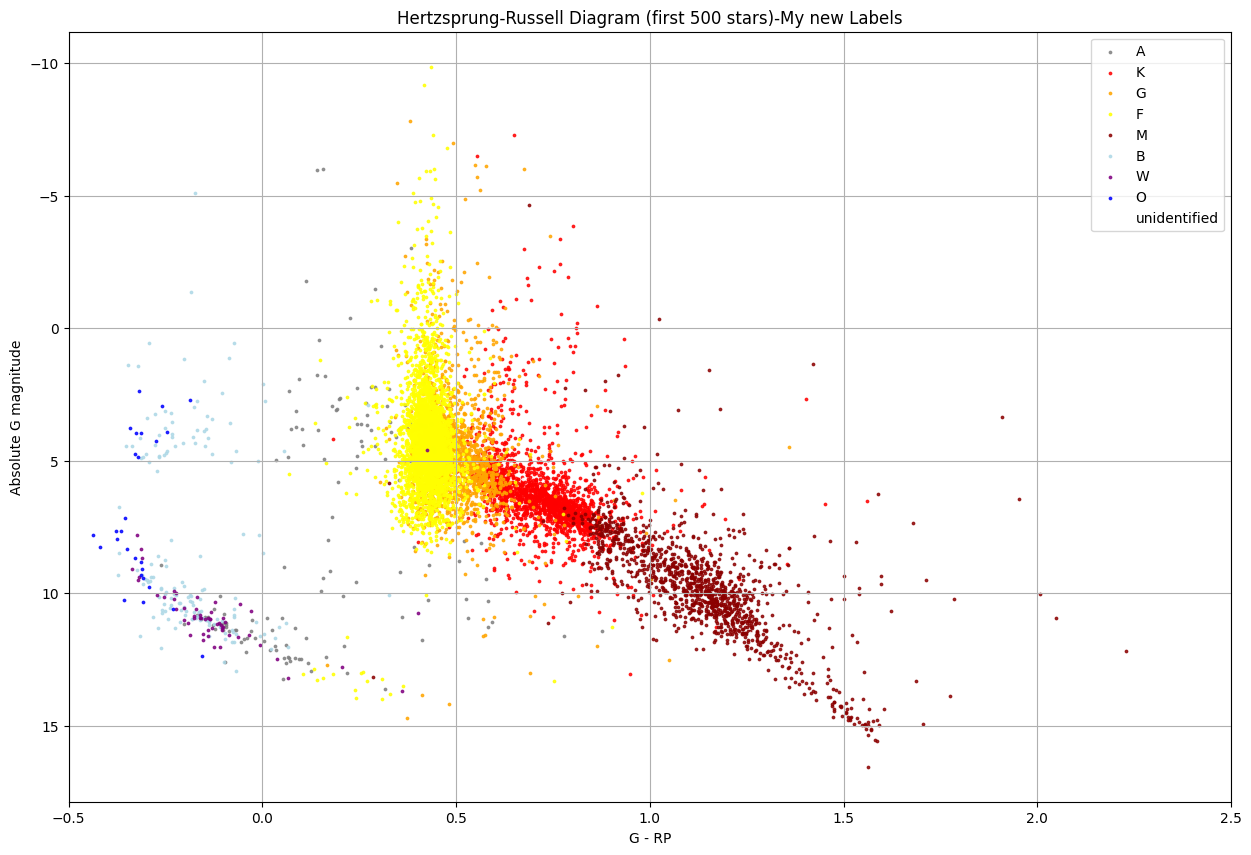

In [ ]:
# Make a broad type column with only the first letter of the spectral type, or 'unidentified' if none of those
df['broad_type'] = df['min_column'].str[0].apply(lambda x: x if x in spectral_color_dict.keys() else 'unidentified')
df['color_index'] = df['g_mag'] - df['rp_mag']

# Create the plot
plt.figure(figsize=(15, 10))

# Loop over each broad type
for broad_type in df['broad_type'].unique():
    # Subset the data
    subset = df[df['broad_type'] == broad_type]

    # Plot the subset with the right color and label
    plt.scatter(subset['color_index'], subset['abs_g_mag'], color=spectral_color_dict[broad_type], alpha=0.8, label=broad_type, s = 3)


# for i in range(len(result_comparison_non_binary_stars_10)):
#     plt.text(result_comparison_non_binary_stars_10['color_index'].iloc[i], result_comparison_non_binary_stars_10['g_mag'].iloc[i], result_comparison_non_binary_stars_10['min_column'].iloc[i], fontsize=10)

plt.xlim(-0.5, 2.5) # Adjust these numbers as necessary

# Flip the y-axis
plt.gca().invert_yaxis()

# Add labels
plt.xlabel('G - RP')
plt.ylabel('Absolute G magnitude')
plt.title('Hertzsprung-Russell Diagram (first 500 stars)-My new Labels')

# Add the legend
plt.legend()

# Add the grid and show the plot
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

# Create a colormap for spectral types
colors = ['darkblue', 'blue', 'lightblue', 'grey', 'yellow', 'orange', 'red', 'darkred']
spectral_types = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
cmap = LinearSegmentedColormap.from_list('spectral_types', colors, N=1000) # Use a large N for a smooth gradient

# Create the plot
plt.figure(figsize=(15, 8))

# Loop over each broad type
for broad_type in df['broad_type'].unique():
    subset = df[df['broad_type'] == broad_type]
    for subclass in subset['min_column'].unique():
        subsubset = subset[subset['min_column'] == subclass]
        color = get_color(broad_type, subclass)
        plt.scatter(subsubset['color_index'], subsubset['abs_g_mag'], color=color, alpha=0.8, s=3)

# Set x-range
plt.xlim(-0.7, 2.2) # Adjust these numbers as necessary

# Flip the y-axis
plt.gca().invert_yaxis()

# Add labels
plt.xlabel('G - RP')
plt.ylabel('Absolute G magnitude')
plt.title('Hertzsprung-Russell Diagram(first 10000 stars)-my labels')

# Create a fake ScalarMappable for the colorbar
norm = plt.Normalize(vmin=0, vmax=len(spectral_types)-1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the colorbar with spectral type labels
cbar = plt.colorbar(sm, ticks=np.arange(len(spectral_types)))
cbar.ax.set_yticklabels(spectral_types)
cbar.set_label('Spectral Types', rotation=270, labelpad=15)

# Add the grid and show the plot
plt.grid(True)
plt.show()


## Getting Gaia's Data

In [ ]:
!pip install astroquery
!pip install gaiaxpy
from astropy.coordinates import Angle
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from astroquery.gaia import GaiaClass
import astropy.units as u
import astropy.coordinates as coord
from gaiaxpy import calibrate
import pandas as pd
import numpy as np
from ast import literal_eval
from gaiaxpy import plot_spectra
from matplotlib import pyplot as plt
import math
from astropy.coordinates import match_coordinates_sky

In [ ]:
import multiprocessing as mp
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
import pandas as pd
import numpy as np
from functools import partial

In [ ]:
result_compare_NonBinary_Stars_CrossMatched = pd.read_csv("/content/drive/MyDrive/AstroResearch/new_data_table/result_compare_CrossMatched_final.csv")
result_compare_NonBinary_Stars_CrossMatched

In [ ]:
long_list = result_compare_NonBinary_Stars_CrossMatched['Gaia_ID'].tolist()
subset_list = long_list[30000]
subset_list

# now running 8000 - 30000
# Finished 80000 -- 110290
# (before 8000): finished in my Gmail account

'732369095940658688'

In [ ]:
import pandas as pd
from gaiaxpy import calibrate

def save_file(id):
    query_input = f"select * from gaiadr3.gaia_source where source_id = {id}"

    try:
        # Only save file when id has corresponding flux/error and wavelength
        calibrated_spectra, sampling = calibrate(query_input)
        sampling_table = pd.DataFrame(sampling)
        sampling_table['flux'] = calibrated_spectra["flux"][0]
        sampling_table['flux_error'] = calibrated_spectra["flux_error"][0]
        sampling_table.columns = ['wavelength', 'flux', 'flux_error']
        file_name = f"{calibrated_spectra['source_id'][0]}.csv"
        path = "drive/MyDrive/AstroResearch/new_data_table/SDSS_gaia_files_8_9_Vu/"
        sampling_table.to_csv(path + file_name, index=None)

    except:
        error_path = "drive/MyDrive/AstroResearch/new_data_table/errors_starting_from_100000.txt"
        with open(error_path, 'a') as file:
            file.write(f"No wavelength or flux from source for {id}\n")

# Sample list of IDs
id_list = subset_list # Add your IDs here

# Apply the save_file function to each ID in the list
current_ID = 0
for id in id_list:
    current_ID = id
    save_file(id)

Input: query_input is a SQL-like string query which is meant to be used to fetch data from the Gaia database. The query retrieves all columns from gaiadr3.gaia_source for a specific source_id.
Output: The method returns two main things:
calibrated_spectra: This appears to be a dictionary or DataFrame-like object that contains the calibrated spectral data, including flux and flux error values, for the specified source_id.
sampling: This seems to represent the wavelength values at which the flux was sampled or measured.

What's happening in save_file(id):

For the given source_id, the query is formulated.
The calibrate method is then called with this query. If successful, it retrieves the calibrated spectra and wavelength values.
Next, the code constructs a sampling_table DataFrame, wherein the columns are populated with wavelength values, the calibrated flux values, and their respective errors.
The processed data is then saved to a CSV file with the name derived from the source_id. This file is saved in a specific path.
If any error occurs (like missing flux, wavelength, or other database-related errors), the source_id causing the error is appended to an error log.


Meaning of calibrated_spectra, sampling = calibrate(query_input):

This is a tuple unpacking in Python. The calibrate function returns two values: the calibrated spectra and the sampling. The first value (calibrated_spectra) is stored in the calibrated_spectra variable, and the second value (sampling) is stored in the sampling variable.


The calibration ensures that the spectral data is adjusted and processed in a way that makes it more reliable and comparable across different observations or instruments. Calibration usually involves removing instrument-related biases, scaling the data, or even correcting for known artifacts. The exact nature of the calibration would depend on how the calibrate method is implemented in the gaiaxpy package, which isn't provided here.
